In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches
import pymc as pm
import arviz as az

/Users/Prabhani/opt/anaconda3/lib/python3.9/site-packages/pyds9.py:94: UserWarning: Can't locate the X11 DS9 executable in your PATH or the Aqua SAOImage DS9 app in /Applications, $HOME or $HOME/Applications. Please configure your PATH or make SAOImage DS9 available in a known location.
  warnings.warn(ds9_warning)


In [2]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [3]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [4]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

In [5]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [6]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

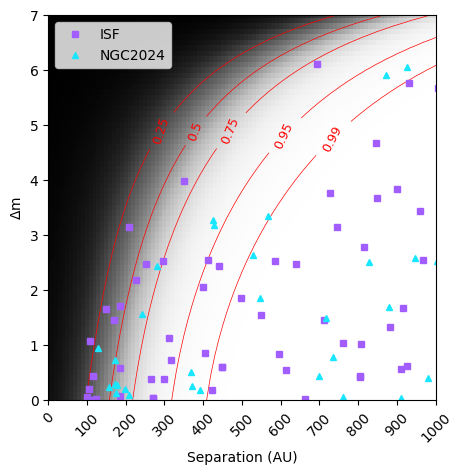

In [7]:
dms = np.arange(0, 7.01, 1/10)
seps = np.arange(0, 2001., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
        r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
        mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, 's', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 70)

ax.set_xlim(0, 100)
ax.legend()

In [8]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        
        
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
            for j in range(len(i_cont)):
                delta_m = m_cat[i_cont[j]]-m_prim
                cont_m = np.append(cont_m, m_cat[i_cont[j]])
                dm_int  = int(np.abs(10*np.round(delta_m, 1)))
                if dm_int>70: #80: delta_mag=8
                    mu_, sig_ = 0, 0
                    R_ = 0
                else:
                    mu_  = mu[dm_int]
                    sig_ = sig[dm_int]
                    I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                    R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                    R  = np.append(R, R_)
                    d_mag=np.append(d_mag,dm_int)
                    R_unc   = np.append(R_unc, I[1])
                    dist = np.append(dist, sep_[i_cont[j]])
                n_cont  = n_cont + R_
                
            N_cont_corr = np.append(N_cont_corr, n_cont)
            N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                          len(i_cont)*
                                          (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
            N_cont = N_cont + n_cont

        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - N_cont
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: ', N_cand)
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF ('+str(N_total)+'): ', N_comp/N_total)
    return d_mag, R, dist, cont_m, bins, bin_count

In [9]:
dmag, R, dist, cmag, sig_bins, bin_count,  = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand:  92
N_cont within 200-5000 (before correction):  40.307142857142864
N_cont within 200-5000:  32.34704739197906
N_contaminants:  855.0
N_comp:  59.65295260802091
CF (671):  0.0889015687153814


In [11]:
bw=100
bin_radii = bin_count*bw
bin_areas = np.pi*((bin_radii)**2-(bin_radii-bw)**2)
bin_mean = np.mean(sig_bins, axis=0)/bin_areas

P($<\Delta$m) = $\frac{r^2 - r^2_{100}}{r^2_{1000} - r^2_{100}}$

In [12]:
def P_r(r1, r2, dr):
    r = np.arange(r1, r2, dr)
    return (r**2 - r1**2)/(r2**2 - r1**2)

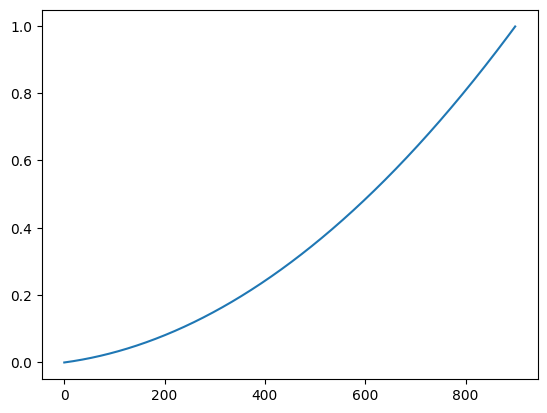

In [15]:
fig, ax = plt.subplots()
ax.plot(P_r(100, 1000, 1))